<a href="https://colab.research.google.com/github/jamslaugh/Data-Science-Projects/blob/main/floward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Dependencies installation
# @markdown Here we install `categorical_encoding` and `featuretools` libraries
!pip install -q categorical_encoding
!pip install -q featuretools==0.9.0

     |████████████████████████████████| 362 kB 5.3 MB/s 
     |████████████████████████████████| 87 kB 6.0 MB/s 
     |████████████████████████████████| 207 kB 53.1 MB/s 
     |████████████████████████████████| 280 kB 53.5 MB/s 
     |████████████████████████████████| 223 kB 5.0 MB/s 


# Modeling Food Preparation Time

Food preparation time has two elements to be considered, that are:

- The average time a certain food requires to be fully prepared
- The amount of queued orders (in terms of time) for that particular restaurant

Now, let's suppose one restaurant can prepare all the orders he receives always in parallel. What happens is that only the first element is necessary. Indeed, if a restaurant has a limited kitchen, as they usually have, we have an overlapping problem between foods and orders.

For example, let's consider an Italian restaurant that receives first an order regarding the preparation of a sea bream in crazy water (preparation time 45') and then, after 5 mintues, gets an order for a Sicilian sauce Spaghetti (preparation time 15'). The times provided are already extremely optimized and this restaurant can only prepare one order at a time.

In this case, what happens is that the preparation time for the second order is of 55'. This happens because we sum up:

$$total\_seconds\_prep\_time=res\_prep\_time\_order1 + prep\_time\_order2$$

However, this is very simplicistic. Often we don't know if restaurants can prepare multiple orders in parallel and to which extent the queue effect can be captured. This is where statistics comes into place. In fact, queues affect interaction times of all the next orders, so we can keep in mind that in developing our model.

The model is a regression model, since we want to predict a continuous quantity.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import (
    LinearRegression as lr, 
    Lasso as ls, 
    LassoCV as lscv
    )
from xgboost import XGBRegressor as xgbr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import hyperopt

In [2]:
data_path = "./drive/MyDrive/floward/"

orders = pd.read_csv(data_path+"orders.csv")
restaurants = pd.read_csv(data_path+"restaurants.csv")

In [3]:
display(orders.head())
display(restaurants.head())

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds
0,2015-06-01 12:28:28.952789+01:00,2015-06-01 14:12:09.474896+01:00,59.90,1326,2,6220
1,2015-06-06 17:06:24.434807+01:00,2015-06-06 17:16:27.520253+01:00,24.00,1326,8,603
2,2015-06-08 14:56:15.503204+01:00,2015-06-08 15:03:39.397496+01:00,15.25,1326,3,443
3,2015-06-12 15:12:20.497925+01:00,2015-06-12 15:23:30.064683+01:00,28.05,1326,8,669
4,2015-06-01 13:07:10.794050+01:00,2015-06-01 14:02:25.104517+01:00,56.30,255,7,3314


,restaurant_id,country,city,type_of_food
0,3,UK,London,thai
1,5,UK,London,italian
2,7,UK,London,italian
3,8,UK,London,chinese
4,9,France,Paris,korean


**Ideas:**

- Type_of_food has anything to do with avg prep_time_seconds?
- Can we spot ciclicity through week days. Maybe, we can use that to model the typical queue. Even better, week day and time of the day.
- We can use avg time in week day and hour without the observation (categorical encoding) to model the typical scenario.
- We can embed the restaurant info in mean encoding or target encoding.

In [4]:
restaurants.type_of_food.unique().shape

(83,)

We can create target encoding for our dataset, but first of it all, let's study a bit further the variable types we have.

In [5]:
print(orders.info())
print(restaurants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32394 entries, 0 to 32393
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_acknowledged_at  32394 non-null  object 
 1   order_ready_at         32394 non-null  object 
 2   order_value_gbp        32394 non-null  float64
 3   restaurant_id          32394 non-null  int64  
 4   number_of_items        32394 non-null  int64  
 5   prep_time_seconds      32394 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   restaurant_id  1697 non-null   int64 
 1   country        1697 non-null   object
 2   city           1697 non-null   object
 3   type_of_food   1697 non-null   object
dtypes: int64(1), object(3)
memory usage: 53.

We need to transform order_acknowlegsd_at and order_ready_at in date time objects. 

In [6]:
orders["order_acknowledged_at"] = pd.to_datetime(orders["order_acknowledged_at"], utc=True)

In [7]:
orders["order_ready_at"] = pd.to_datetime(orders["order_ready_at"], utc=True)

In [8]:
orders_cuisine = orders.merge(restaurants,on="restaurant_id",how="left")

In [9]:
orders_cuisine.head()

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,country,city,type_of_food
0,2015-06-01 11:28:28.952789+00:00,2015-06-01 13:12:09.474896+00:00,59.90,1326,2,6220,UK,London,burritos
1,2015-06-06 16:06:24.434807+00:00,2015-06-06 16:16:27.520253+00:00,24.00,1326,8,603,UK,London,burritos
2,2015-06-08 13:56:15.503204+00:00,2015-06-08 14:03:39.397496+00:00,15.25,1326,3,443,UK,London,burritos
3,2015-06-12 14:12:20.497925+00:00,2015-06-12 14:23:30.064683+00:00,28.05,1326,8,669,UK,London,burritos
4,2015-06-01 12:07:10.794050+00:00,2015-06-01 13:02:25.104517+00:00,56.30,255,7,3314,UK,London,chinese


Let's find out how many of different types of food there are among orders.

In [10]:
orders_cuisine["type_of_food"] = orders_cuisine["type_of_food"].str.replace(" / brunch","")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]),
 <a list of 82 Text major ticklabel objects>)

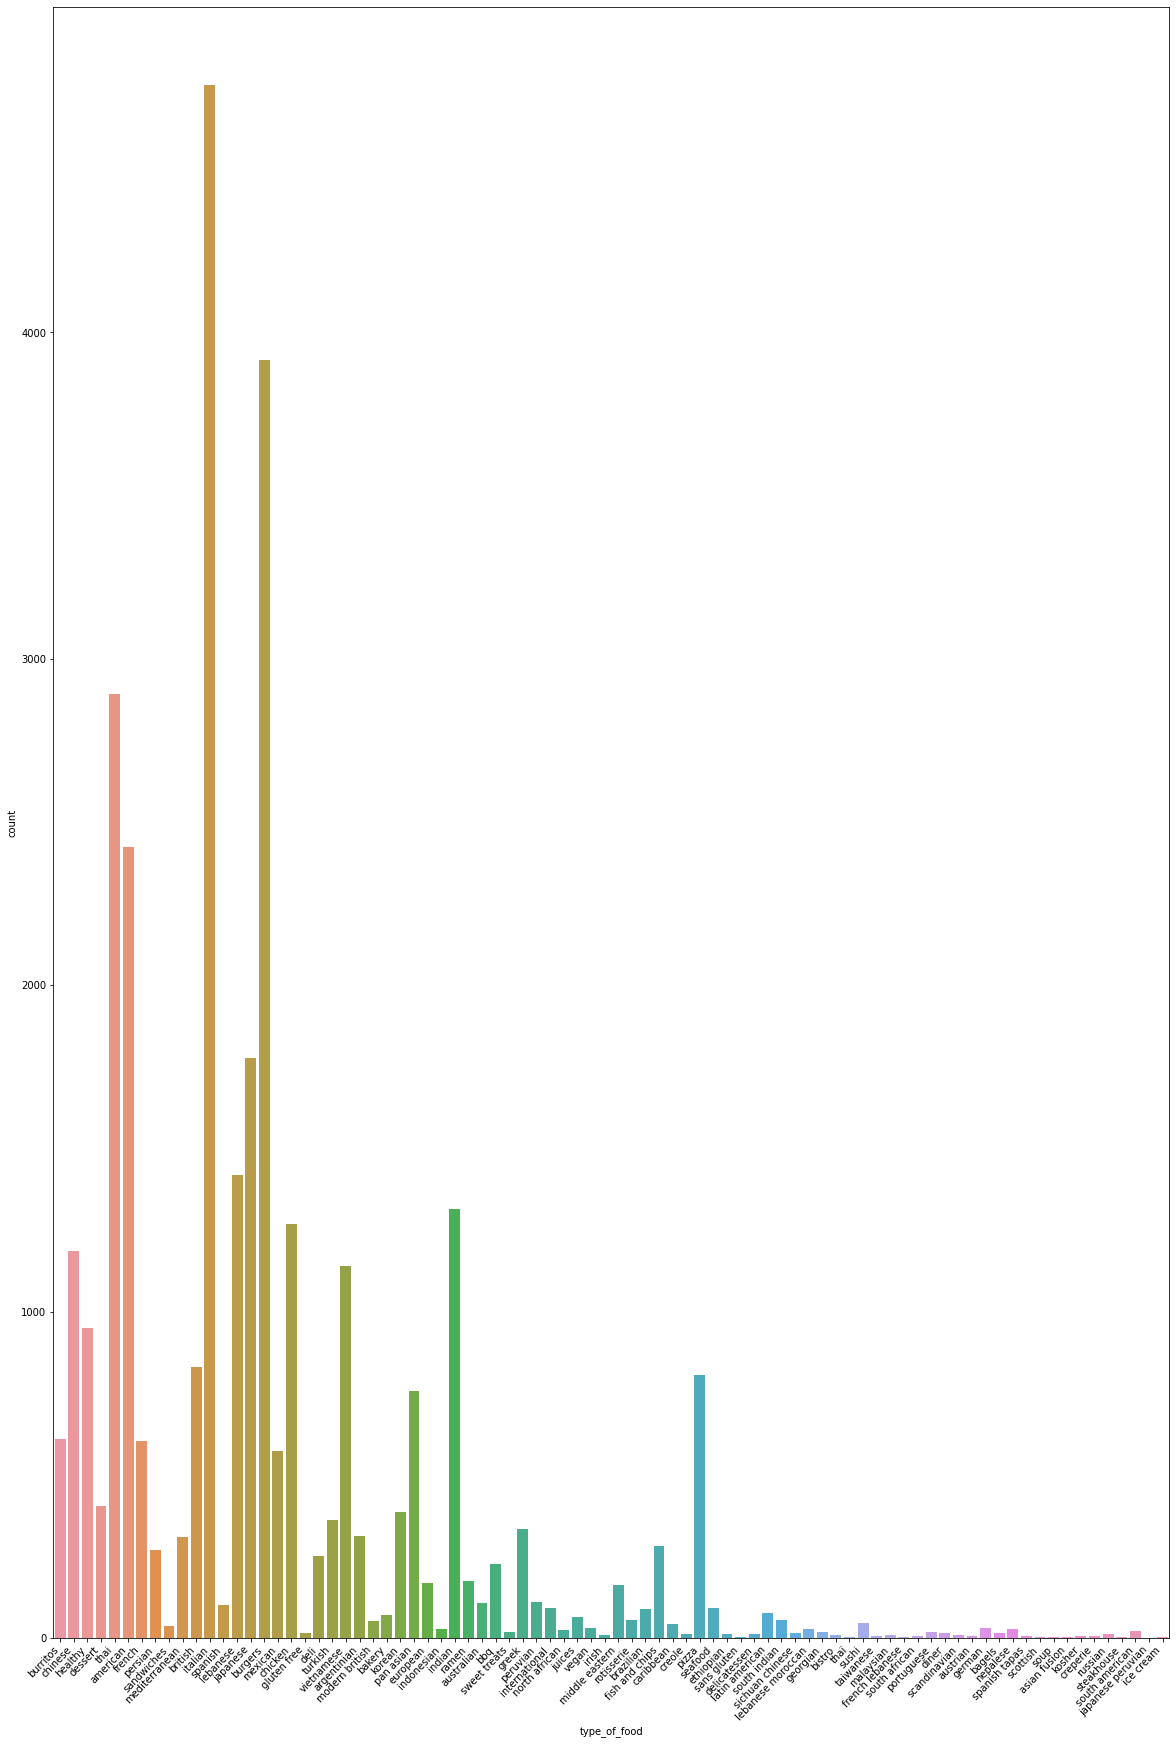

In [11]:
fig, ax = plt.subplots(figsize=(20,30))
ax=sns.countplot(orders_cuisine["type_of_food"],orient="h",ax=ax)
plt.xticks(rotation=46,ha="right")

From the visualization above, it seems that the most ordered food in weeks is the Italian cuisine. So, longer preparation... How are them related?

In [12]:
orders_cuisine["day_of_week"] = orders_cuisine.order_ready_at.dt.day_of_week

So, we only have july and june as our referring data. How many orders are there? We have to aggregate the number of items and the orders that there are per day of the week, to discover if there is a trend or a seasonality effect in our data.

In [13]:
import numpy as np

In [14]:
orders_cuisine.groupby(["day_of_week"]).agg({"type_of_food":"count","number_of_items":"sum","prep_time_seconds":"mean"}).rename({"type_of_food":"Number of orders","number_of_items":"Total items prepared","prep_time_seconds":"AVG preparation time"},axis=1)

,Number of orders,Total items prepared,AVG preparation time
day_of_week,,,
0,4627,18166,1172.465096
1,4688,18830,1275.567406
2,3938,15450,1489.090909
3,3808,15227,1491.473477
4,4906,20391,1545.727884
5,4929,20116,1098.809698
6,5498,22229,1121.171335


It seems that as the week approaches to friday, people tend to order more. Let's check if there is any kind of relationship with the parts of the day.

In [15]:
b = [0,4,8,12,16,20,24]
l = [0, 1, 2, 3, 4, 5]
orders_cuisine["hours"] = orders_cuisine["order_acknowledged_at"].dt.hour
orders_cuisine["daytime_ack"] = pd.cut(orders_cuisine["hours"],bins=b, labels=l,include_lowest=True)
orders_cuisine = orders_cuisine.drop("hours",axis=1)
orders_cuisine["hours"] = orders_cuisine["order_ready_at"].dt.hour
orders_cuisine["daytime_rdy"] = pd.cut(orders_cuisine["hours"],bins=b, labels=l,include_lowest=True)
orders_cuisine = orders_cuisine.drop("hours",axis=1)

In [16]:
orders_cuisine.head()

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,country,city,type_of_food,day_of_week,daytime_ack,daytime_rdy
0,2015-06-01 11:28:28.952789+00:00,2015-06-01 13:12:09.474896+00:00,59.90,1326,2,6220,UK,London,burritos,0,2,3
1,2015-06-06 16:06:24.434807+00:00,2015-06-06 16:16:27.520253+00:00,24.00,1326,8,603,UK,London,burritos,5,3,3
2,2015-06-08 13:56:15.503204+00:00,2015-06-08 14:03:39.397496+00:00,15.25,1326,3,443,UK,London,burritos,0,3,3
3,2015-06-12 14:12:20.497925+00:00,2015-06-12 14:23:30.064683+00:00,28.05,1326,8,669,UK,London,burritos,4,3,3
4,2015-06-01 12:07:10.794050+00:00,2015-06-01 13:02:25.104517+00:00,56.30,255,7,3314,UK,London,chinese,0,2,3


Before proceeding to EDA, we encode the day of the week in a bimodal variable, is_weekend, that is 1 if the considered day is during the weekend (day_of_weeek > 3, that is from Friday up to Sunday) and 0 otherwise.

In [17]:
orders_cuisine["is_weekend"] = (orders_cuisine["day_of_week"] > 3).astype(int)

## EDA

From the data we have, we need to:

1. Consider if the city in which a restaurant is has some kind of interaction with the preparation time
2. Reduce the dimensionality of type_of_food through target encoding
3. Consider some effect from the day of the week in which the order starts.
4. If a particular cuisine is heavily requested, we want to consider also the queue effect. In this case, however, the queue effect, which is partially captured by the time difference between order acknowledged and order ready.

Let's study how the target variable is distributed:

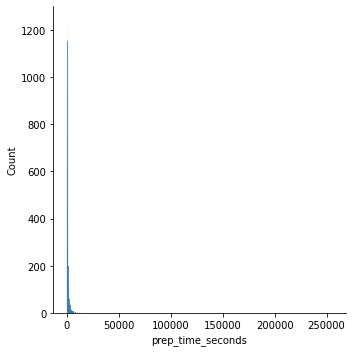

In [18]:
sns.displot(orders_cuisine["prep_time_seconds"])

The target variable has a very long tail. Let's investigate that!

In [19]:
orders_cuisine[orders_cuisine["prep_time_seconds"]>=orders_cuisine["prep_time_seconds"].quantile(0.98)].sort_values("prep_time_seconds",ascending=False)

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,country,city,type_of_food,day_of_week,daytime_ack,daytime_rdy,is_weekend
9807,2015-06-19 13:22:41.266706+00:00,2015-06-22 12:21:01.135043+00:00,76.80000,441,5,255499,UK,London,pan asian,0,3,2,0
31228,2015-06-22 11:16:57.633240+00:00,2015-06-23 19:30:56.247886+00:00,44.36875,3242,5,116038,France,Paris,thai,1,2,4,0
13166,2015-06-27 13:28:38.597727+00:00,2015-06-28 20:54:35.806404+00:00,18.50000,1471,4,113157,UK,London,burgers,6,3,4,1
31749,2015-06-23 13:18:09.813573+00:00,2015-06-24 20:22:06.763008+00:00,276.86100,3338,6,111836,France,Paris,italian,2,3,4,0
20760,2015-06-03 12:03:57.396860+00:00,2015-06-04 18:40:36.103611+00:00,16.00000,1150,2,110198,UK,London,italian,3,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,2015-06-05 18:47:26.797827+00:00,2015-06-05 20:11:46.784054+00:00,34.10000,12,5,5059,UK,London,korean,4,4,4,1
25180,2015-06-10 11:21:12.209347+00:00,2015-06-10 12:45:22.353759+00:00,28.50000,2855,4,5050,UK,London,american,2,2,2,0
29470,2015-06-21 11:11:58.000609+00:00,2015-06-21 12:36:08.120036+00:00,43.00000,2730,7,5050,UK,Edinburgh,lebanese,6,2,2,1
28645,2015-06-27 19:18:15.727729+00:00,2015-06-27 20:42:21.547472+00:00,77.35000,462,8,5045,UK,London,thai,5,4,4,1


From what we can see, there are orders that lasted too much. The idea here is to remove the outliers, before proceeding with the task. In order to do that, we consider an order valid only if it's preparation time falls within an hour time limit (that is 3600 seconds).

In [20]:
orders_cuisine = orders_cuisine[orders_cuisine.prep_time_seconds < 3600]

Similarly, we will keep only the preparation time in seconds which are greater than 0.

In [21]:
orders_cuisine = orders_cuisine[orders_cuisine.prep_time_seconds > 0]

In [22]:
sns.set(font_scale=1)

Text(0.5, 8.95999999999998, 'Preparation Time in Seconds')

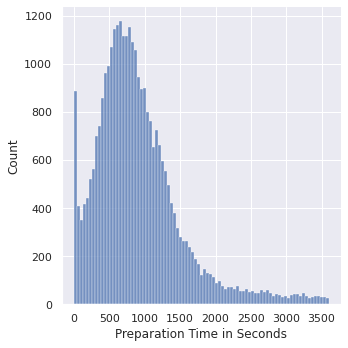

In [23]:
sns.displot(orders_cuisine["prep_time_seconds"])
plt.xlabel("Preparation Time in Seconds")

In [24]:
orders_cuisine["order_value_gbp_avg"] = orders_cuisine.order_value_gbp.div(orders_cuisine.number_of_items)

Text(0.5, 8.95999999999998, 'Average Order Value in GBP')

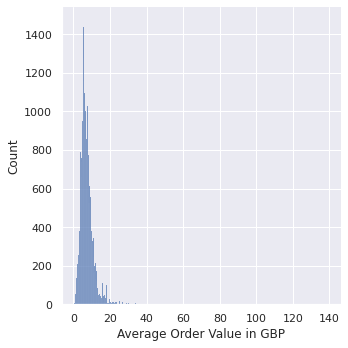

In [25]:
sns.displot(orders_cuisine["order_value_gbp_avg"])
plt.xlabel("Average Order Value in GBP")

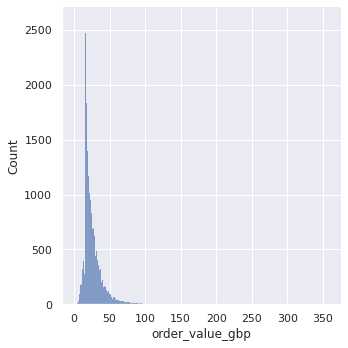

In [26]:
sns.displot(orders_cuisine["order_value_gbp"])

Text(0.5, 8.95999999999998, 'Number of Items')

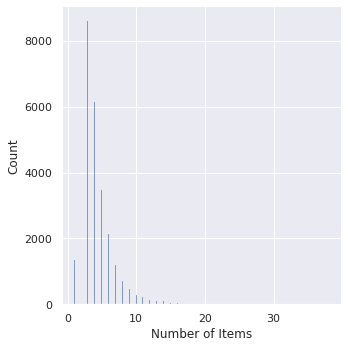

In [27]:
sns.displot(orders_cuisine["number_of_items"])
plt.xlabel("Number of Items")

As we can see, there are orders that required more than a day to be prepared. This is quite strange. Also some orders required more than two hours. In this case, we have that those orders are clearly outliers. Maybe the tracking app had a bug or another kind of malfunctioning.

In [28]:
ord_grouped = orders_cuisine.groupby(["is_weekend","day_of_week", "daytime_ack","type_of_food"]).agg({"type_of_food":"count","number_of_items":"sum",'prep_time_seconds':"mean"})

In [29]:
ord_grouped = ord_grouped.rename({"type_of_food":"count_type_of_food"},axis=1)

In [30]:
ord_grouped = ord_grouped.reset_index()

In [31]:
ord_grouped.head()

,is_weekend,day_of_week,daytime_ack,type_of_food,count_type_of_food,number_of_items,prep_time_seconds
0,0,0,0,american,0,0,NaN
1,0,0,0,argentinian,0,0,NaN
2,0,0,0,asian fusion,0,0,NaN
3,0,0,0,australian,0,0,NaN
4,0,0,0,austrian,0,0,NaN


In [32]:
ord_grouped = ord_grouped.dropna()

In [33]:
sns.set(font_scale=2)

Text(0.5, 0, 'Day of the week')

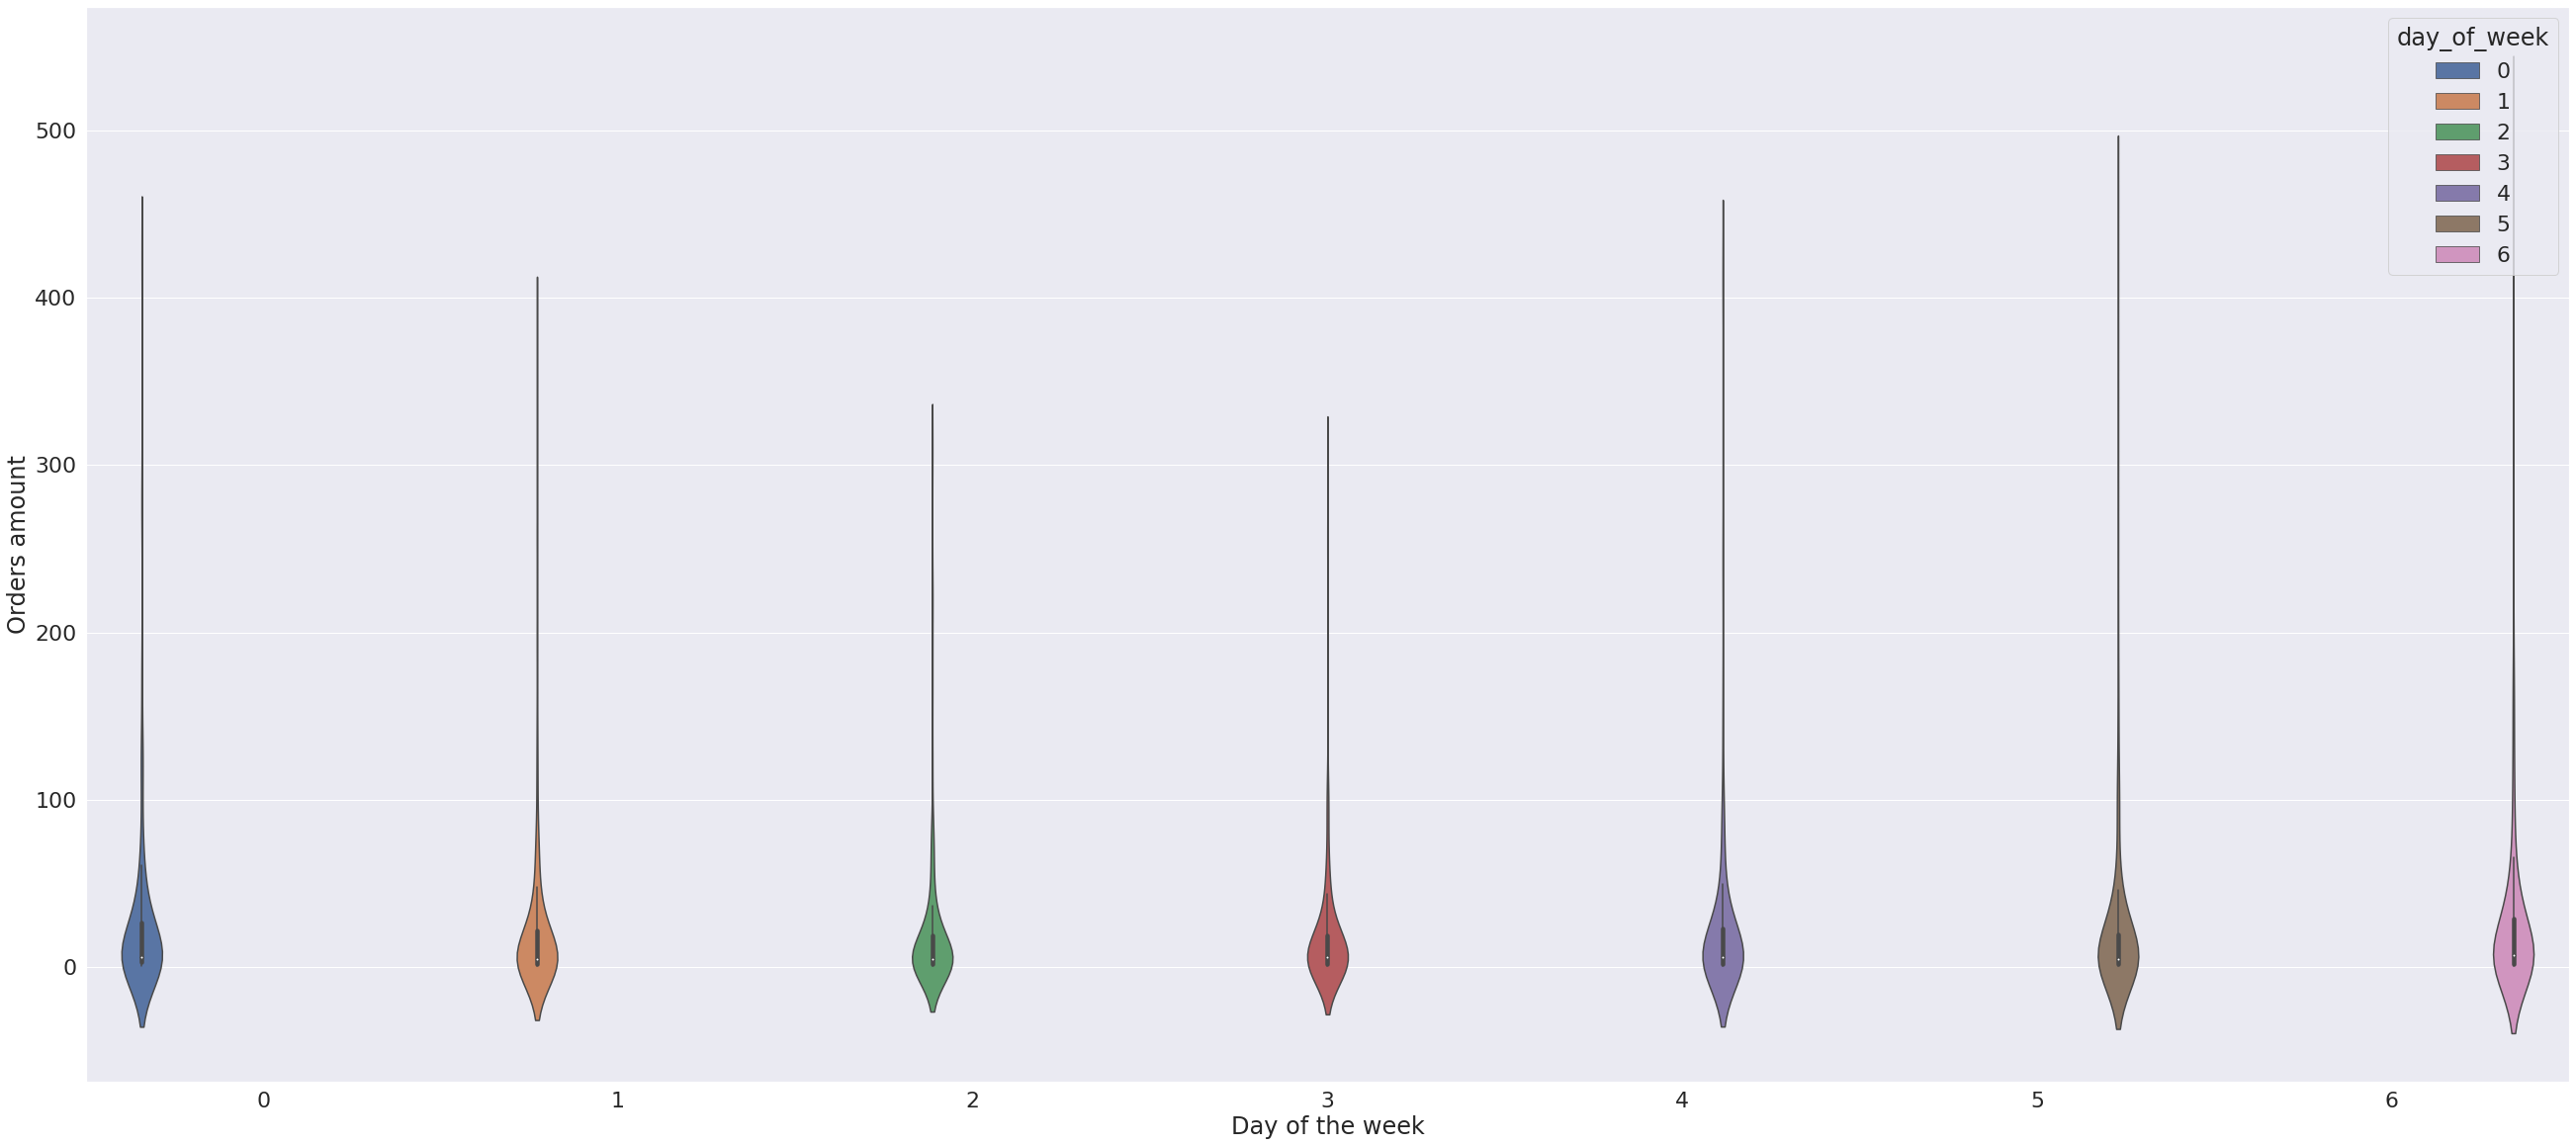

In [34]:
plt.subplots(figsize=(45,20))
ax = sns.violinplot(y="count_type_of_food",x="day_of_week",hue="day_of_week",data=ord_grouped)
ax.set_ylabel("Orders amount")
ax.set_xlabel("Day of the week")
# plt.xticks(rotation=45,ha="right")

Text(0.5, 0, 'Day of the week')

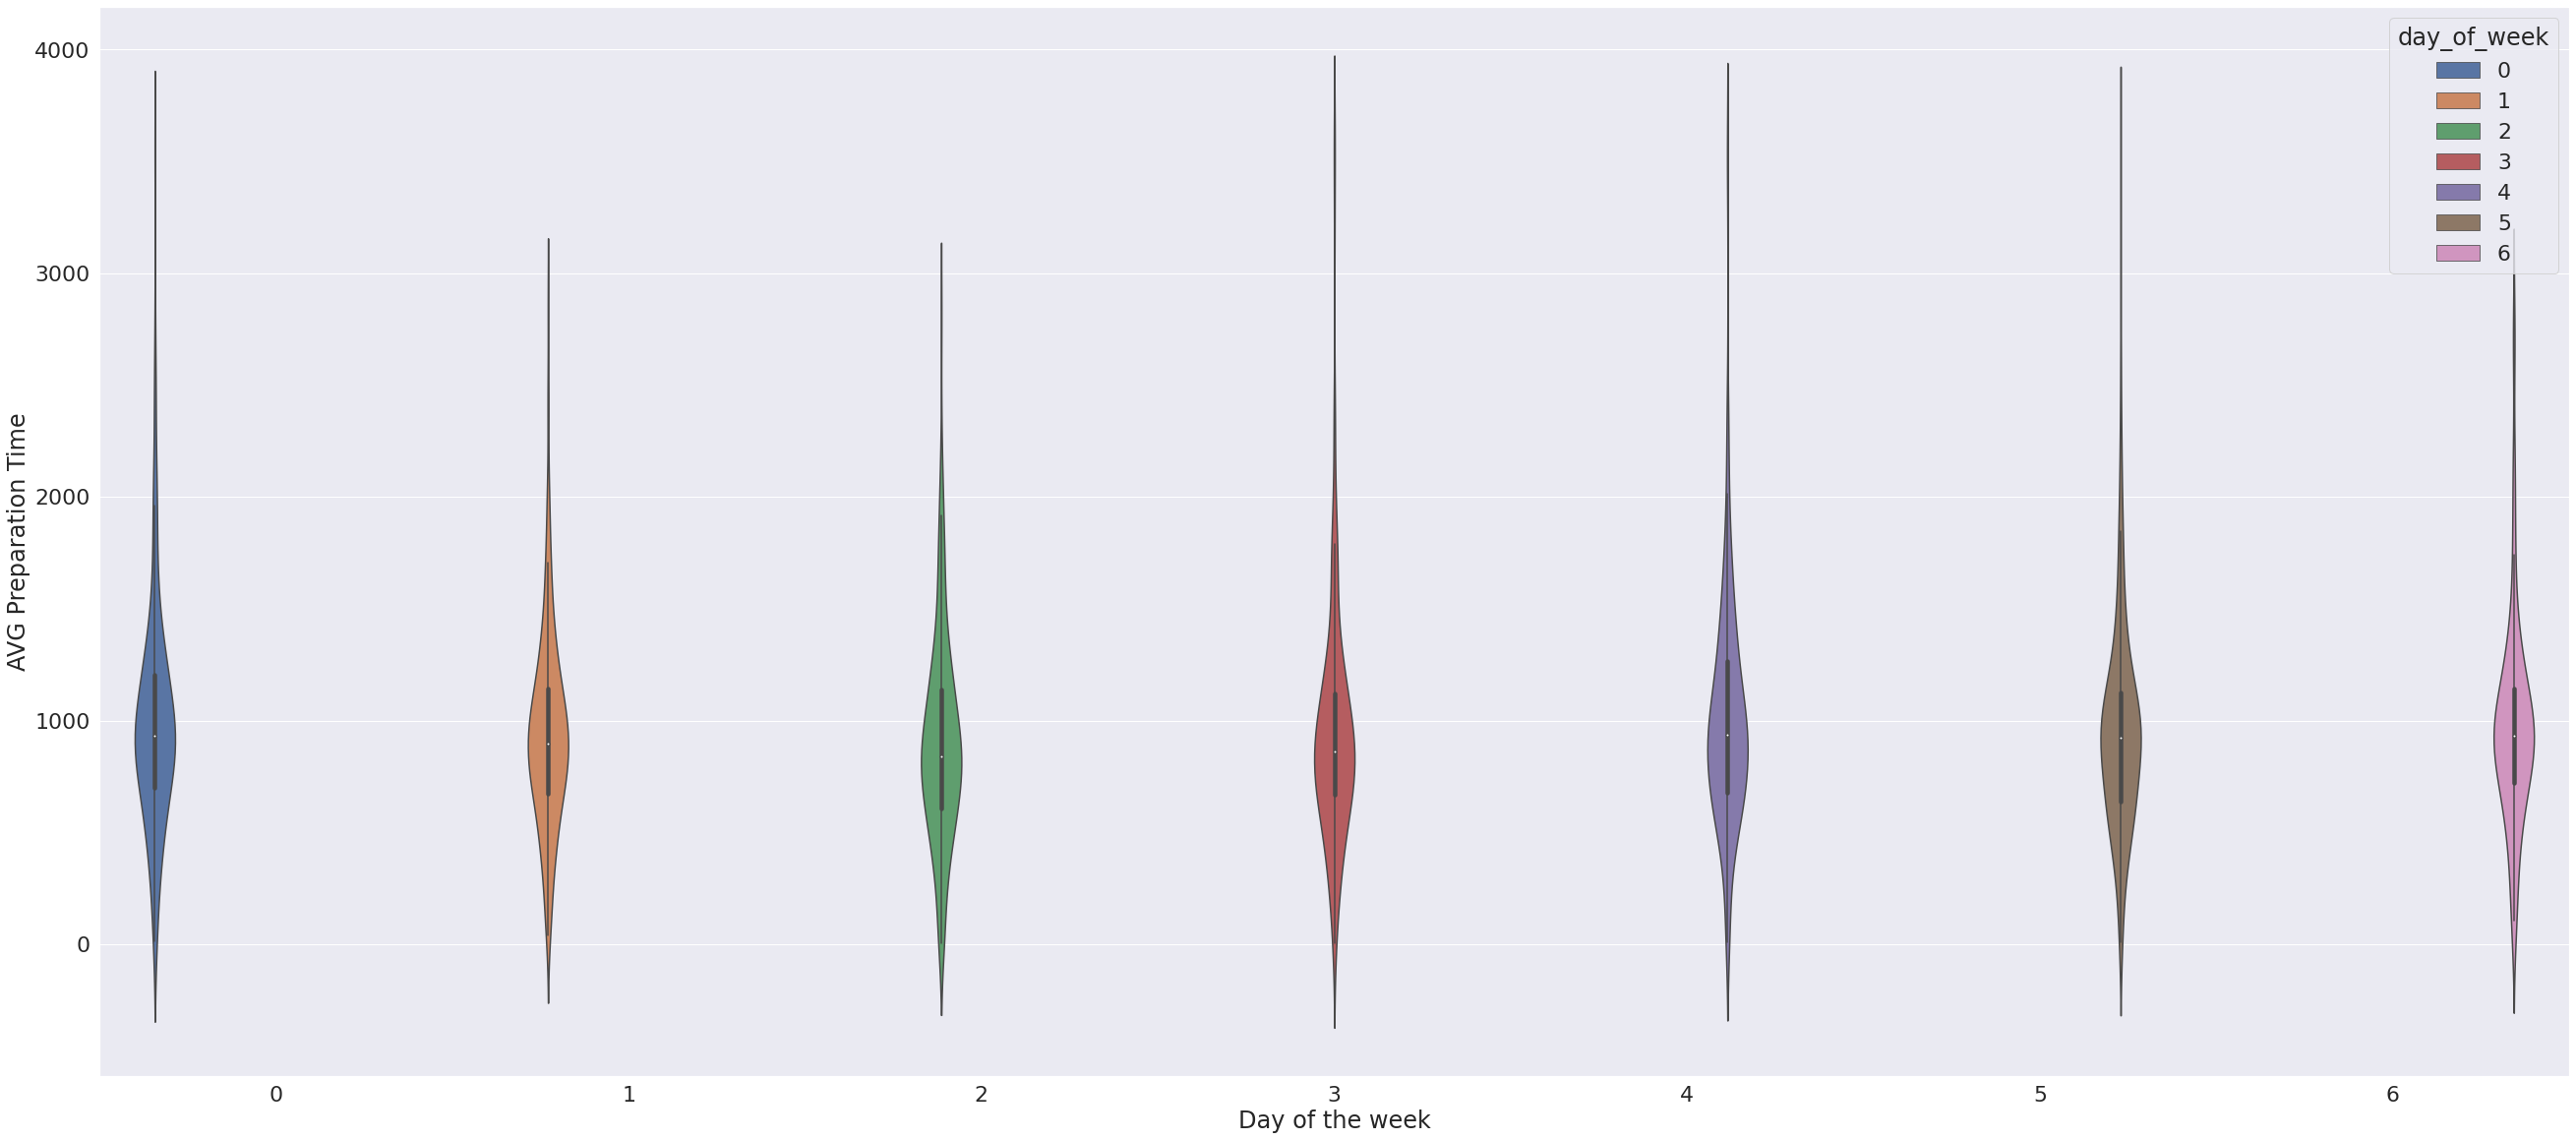

In [35]:
plt.subplots(figsize=(45,20))
ax = sns.violinplot(y="prep_time_seconds",x="day_of_week",hue="day_of_week",data=ord_grouped)
ax.set_ylabel("AVG Preparation Time")
ax.set_xlabel("Day of the week")
# plt.xticks(rotation=45,ha="right")

From the above graphs, it is possible to note that the orders amount tend to be greater and vary more during weekends, while the preparation time is greater on Tuesday and smaller in weekends. This might be due to the fact that during weekends  kitchens tend to be more optimized in weekends than in the beginning of the week. 

Moreover, there might be some dependency between the time of the day and the week day in which a new order is prepared. To confirm this hypotesis we run a chi-square test on a contingency table.

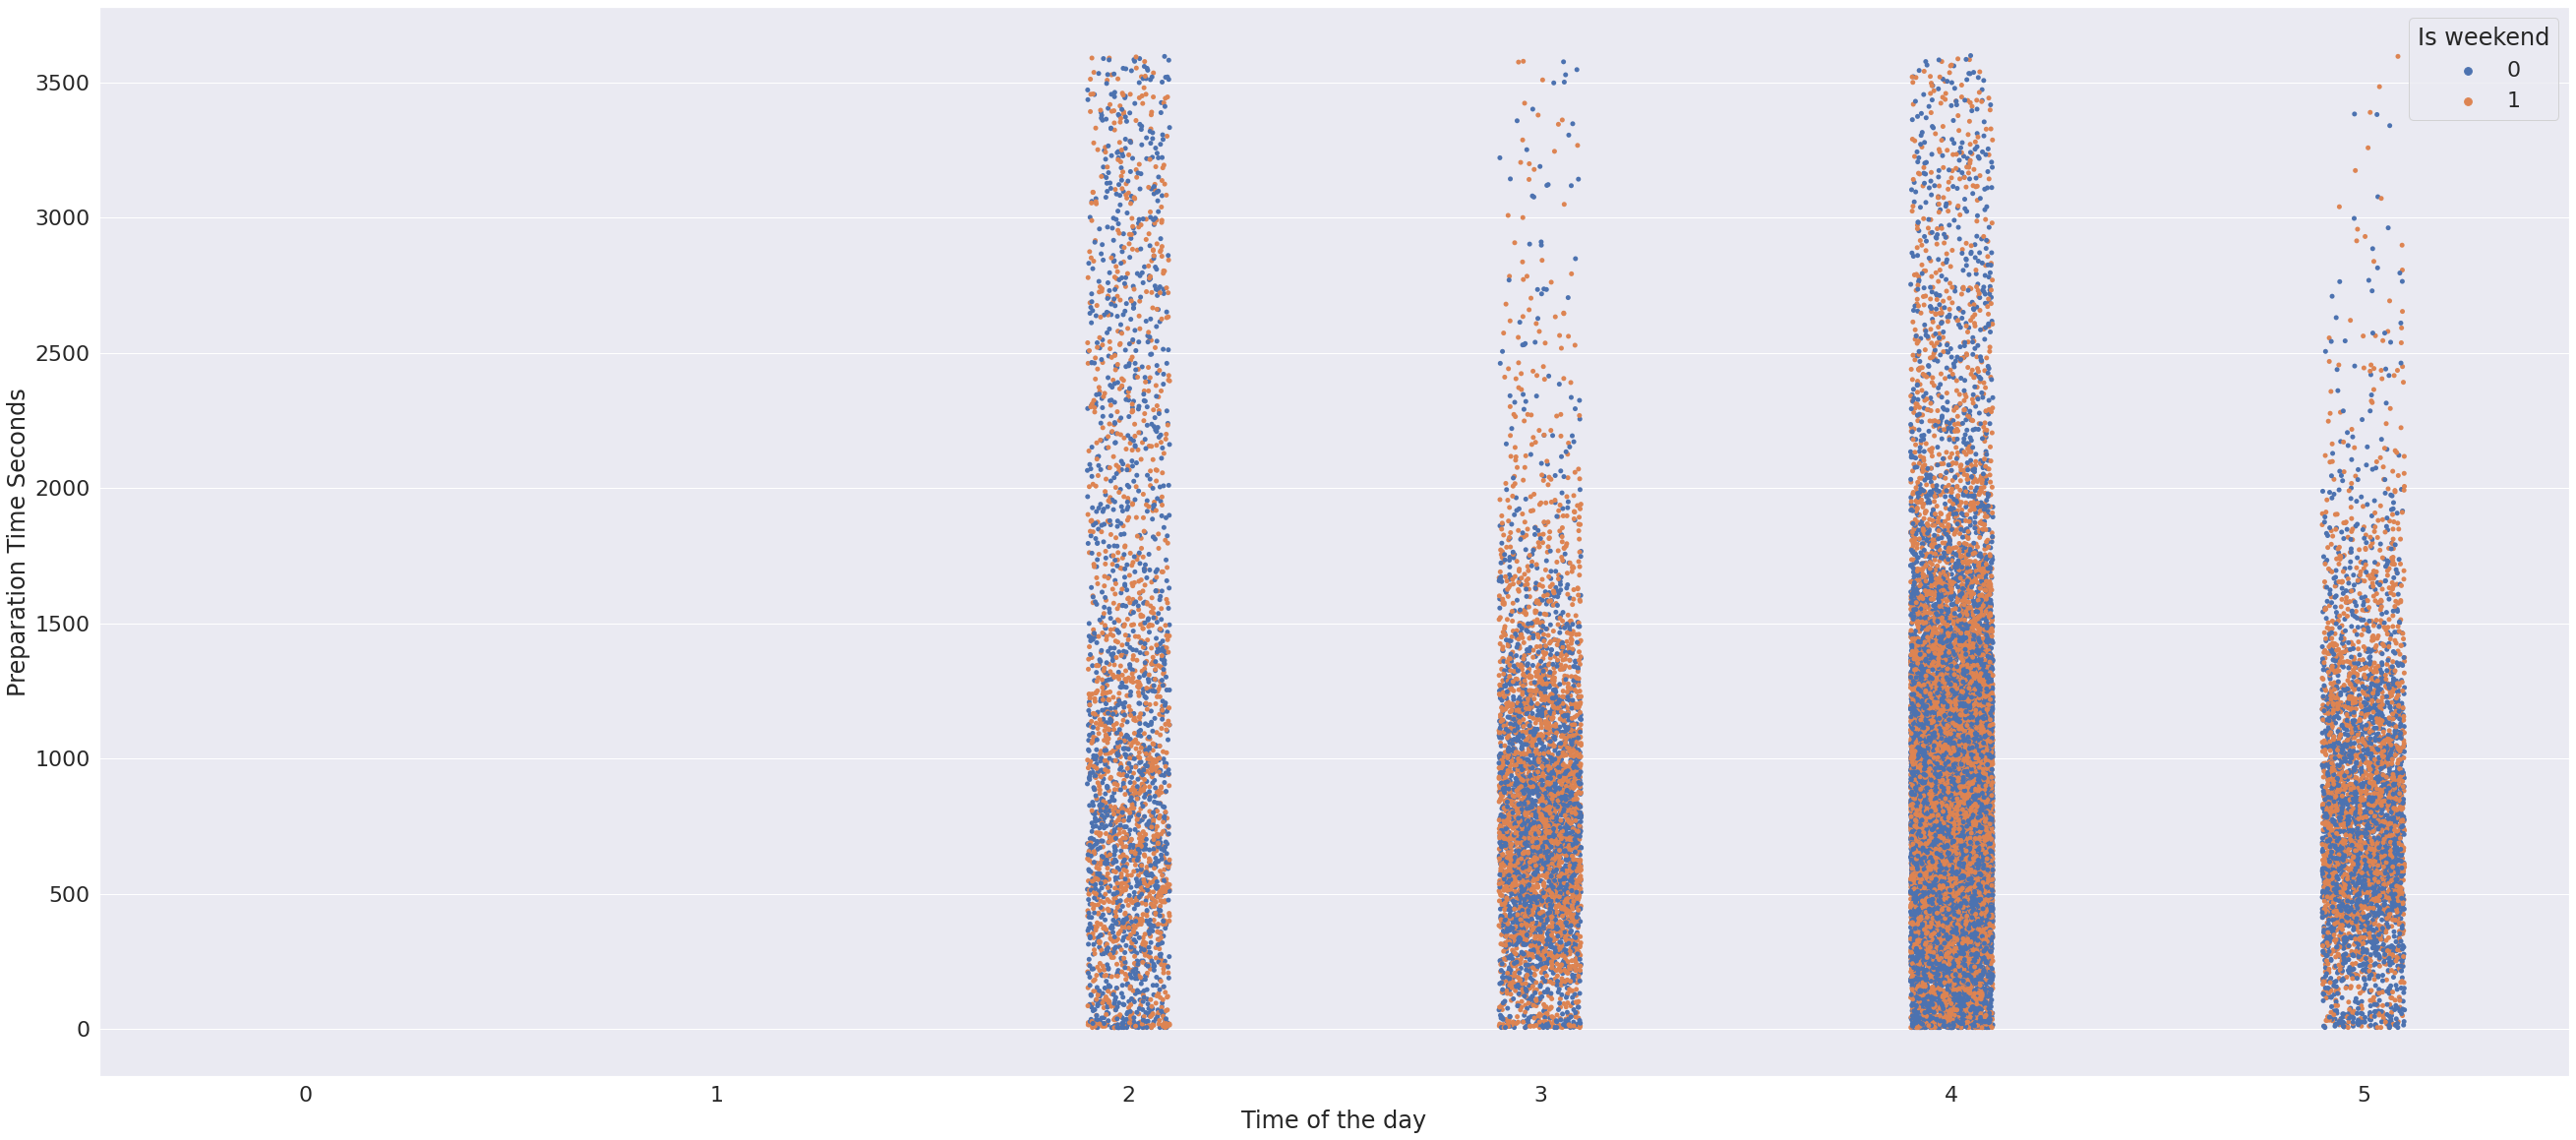

In [36]:
# @title Order duration Swarmplot
# @markdown We can also have a look on how order duration moves towards the week and towards the weekends.
plt.subplots(figsize=(45,20))
ax = sns.stripplot(x="daytime_ack",y="prep_time_seconds",data=orders_cuisine, hue="is_weekend")
ax.set_xlabel("Time of the day")
ax.set_ylabel("Preparation Time Seconds")
ax.legend(title="Is weekend")

In [37]:
# @title Time of the week - Day of the week correlation
# @markdown By a Chi-square test, we notice that there is a statistical dependence for the number of orders between day of the week and the different part of the day the order has started. <br> In particular, during weekends people tend to order more and overall the orders tend to be focused at evening, dinner time.
import scipy.stats as stats
orders_grouped_crosstab = pd.crosstab(orders_cuisine.daytime_ack,orders_cuisine.day_of_week,margins=True, margins_name="Total")
display(orders_grouped_crosstab)
alpha = 0.05

chi_square = 0
rows = orders_cuisine['daytime_ack'].unique()
columns = orders_cuisine['day_of_week'].unique()
for i in columns:
    for j in rows:
        O = orders_grouped_crosstab[i][j]
        E = orders_grouped_crosstab[i]['Total'] * orders_grouped_crosstab['Total'][j] / orders_grouped_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

day_of_week,0,1,2,3,4,5,6,Total
daytime_ack,,,,,,,,
2,368,403,372,327,548,367,497,2882
3,710,599,518,446,529,920,1247,4969
4,2781,2816,2293,2271,2743,2730,3005,18639
5,604,722,555,578,820,759,608,4646
Total,4463,4540,3738,3622,4640,4776,5357,31136


Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 505.27913507097304  and p value is: 0.0
Null Hypothesis is rejected.


We can even test if the average amount of orders in the weekend is different from the amount of orders during the rest of the week. For this we create another column that expresses if the day is part of the weekend (values from 4 to 6 included) or not.

In [38]:
# @title Preparation time with respect to weekend
# @markdown As it is possible to notice,  the data show evidence that the average preparation time tends to be higher in case of weekends.
values = stats.ttest_ind(orders_cuisine.loc[orders_cuisine.is_weekend==1,"prep_time_seconds"],
                orders_cuisine.loc[orders_cuisine.is_weekend==0,"prep_time_seconds"])
if values.pvalue <= alpha:
    print("There is a statistical difference in mean between weekends and midweek")
    print("The T value is: ",values.statistic)

There is a statistical difference in mean between weekends and midweek
The T value is:  7.5104032172175605


According to this last test, the preparation time in seconds shows some dependency on wether or not the day is during the weekend or not.

## ML modeling

We need to target encode the variables we have seen. As stated above, there are clearly some outliers. As a rule of thumb, we should exclude all the elements in target Variale that are not within 24 hours. Orders that ready after 24 hours are likely to be due to a dangling call of the app or some other sort of technical issue on the same. We have also studied how the number of items predictor and the order_value_gbp are distributed, considering also the order_value_gbp_avg for the average.

In [39]:
orders_cuisine.head()

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,country,city,type_of_food,day_of_week,daytime_ack,daytime_rdy,is_weekend,order_value_gbp_avg
1,2015-06-06 16:06:24.434807+00:00,2015-06-06 16:16:27.520253+00:00,24.00,1326,8,603,UK,London,burritos,5,3,3,1,3.000000
2,2015-06-08 13:56:15.503204+00:00,2015-06-08 14:03:39.397496+00:00,15.25,1326,3,443,UK,London,burritos,0,3,3,0,5.083333
3,2015-06-12 14:12:20.497925+00:00,2015-06-12 14:23:30.064683+00:00,28.05,1326,8,669,UK,London,burritos,4,3,3,1,3.506250
4,2015-06-01 12:07:10.794050+00:00,2015-06-01 13:02:25.104517+00:00,56.30,255,7,3314,UK,London,chinese,0,2,3,0,8.042857
5,2015-06-01 20:01:37.821061+00:00,2015-06-01 20:19:07.464277+00:00,18.20,255,3,1049,UK,London,chinese,0,4,4,0,6.066667


In [40]:
import category_encoders as ce

In the upcoming steps, before building our ML models, we will encode the categorical variables with leave one out method. This method is pretty useful in avoiding data leakage. 

**The main idea** is: we want to encode categorical variables without having a too high expansion in cardinality of our data, in order to show better if there are or not underlying correlations.

The features we are going to select are:

- `restaurant_id`, categorical encoded
- `order_value_gbp_avg`
- `city`, categorical encoded
- `day_of_week`, categorical encoded
- `daytime_ack`, categorical encoded
- `type_of_food`, categorical encoded

We will create also a `queue` feature, by melting the dataframe upon `order_acknowledged_at` and `order_ready_at`, keeping all other variables as id variables, to then pivot to the original data frame.

In [41]:
from typing import Union, List
import pandas as pd

class CategoricalEncoding:

    def __init__(self, ce_model, **model_kwargs):

        """
        Categorical encoding wrapper. 
        :param: model the category_encoding moodel one wants to fit 
        """

        self.enc = ce_model(**model_kwargs)

    def __call__(self, train_data:List[pd.core.frame.DataFrame], test_data:Union[List[pd.core.frame.DataFrame],None]=None, **fit_params):
        
        assert len(train_data) == 2, "Attention, you have to put [X_train, y_train] in train_data."
        X_train = self.enc_fit_transform(train_data[0],train_data[1])
        
        if test_data is not None:
            assert len(test_data) == 2, "Attention, you have to put [X_test, y_test] in test_data if not None."
            X_test = self.enc_transform(test_data[0],test_data[1])
            return X_train, X_test
        return X_train

    def enc_fit_transform(self,X_train, y_train, **fit_params):
        return self.enc.fit_transform(X_train, y_train)
    
    def enc_transform(self, X_test, y_test):
        return self.enc.transform(X_test,y_test)

In [42]:
features = [
    "restaurant_id",
    "order_value_gbp_avg",
    "city",
    "day_of_week",
    "daytime_ack",
    "type_of_food",
    "prep_time_seconds"
    ]
time_features = ["order_acknowledged_at","order_ready_at"]

def queue_creator(df, features:list, sorting_features:list, time_features:list):

    train_df = (df[time_features+features].melt(id_vars=features,
                var_name='type',
                value_name='time').sort_values(by=sorting_features)
        )
    train_df['queue'] = (train_df['type'].map({time_features[0]: 1, time_features[1]: -1})
                            .cumsum()
                )
    return train_df[train_df.type==time_features[0]].drop(["type","time"],axis=1)

train_df = queue_creator(orders_cuisine, features, ["restaurant_id","time"], time_features)

In [43]:
train_df = train_df[["restaurant_id","order_value_gbp_avg","city","day_of_week","daytime_ack","type_of_food","queue","prep_time_seconds"]]

In [44]:
y = train_df["prep_time_seconds"]
enc = CategoricalEncoding(ce.LeaveOneOutEncoder,cols=["restaurant_id","city", "day_of_week", "daytime_ack", "type_of_food"])
X = enc([train_df.drop("prep_time_seconds",axis=1),y])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [46]:
X_train

,restaurant_id,order_value_gbp_avg,city,day_of_week,daytime_ack,type_of_food,queue
7114,396.828829,10.333333,931.329721,943.918969,896.318435,864.721093,1
5823,668.709581,7.316667,931.356974,879.103988,896.354330,882.613500,1
22998,544.351351,7.725000,931.331677,958.527700,896.321011,782.328084,1
13422,914.051282,7.625000,931.333917,958.539556,1245.827490,1024.496737,1
21711,663.826087,4.337500,931.340191,871.985015,896.332224,835.968412,1
...,...,...,...,...,...,...,...
12234,1074.640000,5.750000,931.335424,920.544503,896.325947,966.589051,1
25057,360.000000,8.518800,465.975089,879.152677,896.366187,701.532609,1
3347,704.866667,5.950000,931.356241,872.090447,844.380636,864.826531,1
9576,907.272727,4.350000,931.345934,958.603147,896.339790,932.584945,1


In [47]:
y_train

7114     1043
5823      374
22998     995
13422     940
21711     786
         ... 
12234     903
25057     153
3347      392
9576      645
4790      653
Name: prep_time_seconds, Length: 24908, dtype: int64

### First simple model

To test if our assumption are correct, we test everything with a linear regression.

In [48]:
lin_reg = lr()

In [49]:
lin_reg.fit(X_train,y_train)

LinearRegression()

In [50]:
y_pred = lin_reg.predict(X_test)

In [51]:
(mse(y_test,y_pred))**(1/2)

559.5247662108846

The first model brought a 552 root mean squared error, which is not bad.

We can improve by picking for each restaurant all the samples but the least ones, if there are at least k orders (say 15), or we can improve with random forest regressor as well.

### Testing multiple models at once

We want to go further and test different models at once. In order to do so, we build a function, `best_regression` that simply cycles through a list of regression methods to return the one with the best rmse on training set. We also study the most important feature, by using random forest regressor.

In [52]:
from typing import Union, List, Tuple
import numpy as np
def best_regression(regression_methods: list, X: Tuple[Union[pd.core.frame.DataFrame, np.ndarray], ...], y:Tuple[Union[pd.core.series.Series, np.ndarray], ...]):

    rmse_min = 9e11
    best_method = None
    for reg_method in regression_methods:
        reg = reg_method()
        reg.fit(X[0],y[0])
        pred = reg.predict(X[1])
        rmse = (mse(y[1],pred))**(1/2)
        print(f"Method {str(reg_method)} performed with this rmse: {rmse}")
        if rmse < rmse_min:
            print("new min!")
            rmse_min = rmse
            best_method = reg
    
    return best_method, rmse_min

In [53]:
best_reg0 = best_regression(regression_methods = [lr,ls,lscv,rfr,xgbr], X = (X_train, X_test), y = (y_train, y_test))

Method <class 'sklearn.linear_model._base.LinearRegression'> performed with this rmse: 559.5247662108846
new min!
Method <class 'sklearn.linear_model._coordinate_descent.Lasso'> performed with this rmse: 559.5450902987668
Method <class 'sklearn.linear_model._coordinate_descent.LassoCV'> performed with this rmse: 560.0334324668687
Method <class 'sklearn.ensemble._forest.RandomForestRegressor'> performed with this rmse: 38.44328100607285
new min!
[14:10:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Method <class 'xgboost.sklearn.XGBRegressor'> performed with this rmse: 126.51424533905268


In [54]:
best_reg0

(RandomForestRegressor(), 38.44328100607285)

In [55]:
rand_for = rfr()
rand_for.fit(X_train, y_train)
pred = rand_for.predict(X_test)
print((mse(y_test,pred))**1/2)

782.188196130379


In [56]:
# @title Which is the most important feature?

X_train.columns[rand_for.feature_importances_.argmax()]

'city'

According to random forest regressor, the most important feature that impacts on order preparation time is the city.

Splitting with Train and Test split, however, might have leaked data from future, since the observations are taken totally at random. The 14 seconds of rmse makes me thing that there is a data leakage problem. This is why we proceed in splitting training and test dataset with the techinique indicated below.

### Train and Test built leaving out last n-periods for each restaurant

In this approach, we take all but last k elements from each restaurant present in our dataset. This will obviously be possible only if the restaurant has n orders already in place. Let's remember that `train_df` is already ordered by resaturant and date. So, for each restaurant, we take n-k in training and k in test. Note that $\frac{k}{n} = 20\%$.

This is necessary in order to keep the ordered structure of our data and to avoid, when performing category encoding, data leakage from the future. The restaurants with less than 10 observations will also be discarded.

In [57]:
def panel_train_splitter(test_ratio:float, ds: pd.core.frame.DataFrame, 
                         col_to_split:str="restaurant_id", 
                         min_el:int = 10) -> List[pd.core.frame.DataFrame]:

    unique_ids = ds[col_to_split].unique()
    train = []
    test = []
    leave_out = []
    for id in unique_ids:
        tmp_ds = ds[ds[col_to_split]==id]
        tmp_ds = tmp_ds.reset_index(drop=True)
        tmp_shape = tmp_ds.shape[0]
        if tmp_shape > min_el:
            pos = int(tmp_shape*(1-test_ratio))
            train_id = tmp_ds.index[pos]
            tmp_train = tmp_ds.loc[:train_id,:]
            tmp_test = tmp_ds.loc[train_id+1:,:]
            train.append(tmp_train)
            test.append(tmp_test)
        else:
            leave_out.append(tmp_ds)
    return pd.concat(train,ignore_index=True), pd.concat(test,ignore_index=True), pd.concat(leave_out, ignore_index=True)

In [58]:
train, test, leave_out = panel_train_splitter(0.2, train_df)

#### Train and test sets creation and Data Leakage study.

We proceed in creating train and test sets. We fit the LeaveOneOut encoder only on training set, to then only transform the test set. We have left out from our dataset those restaurant_id that have less than 10 observations.
We further encode the following variables:

- `city`, 
- `day_of_week`, 
- `daytime_ack`, 
- `type_of_food`

After that, we use `pairplot` method to show if there is or not any kind of collinearity among our variables and/or target leakage.

In [59]:
enc = CategoricalEncoding(ce.LeaveOneOutEncoder,cols=["city", "day_of_week", "daytime_ack", "type_of_food"])

In [60]:
y_train = train.prep_time_seconds
y_test = test.prep_time_seconds
X_train, X_test = enc([train.drop("prep_time_seconds",axis=1),y_train],[test.drop("prep_time_seconds",axis=1),y_test])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Collinearity and Target Leakage:**

There is no collinearity or target leakage in our data, as shown here.

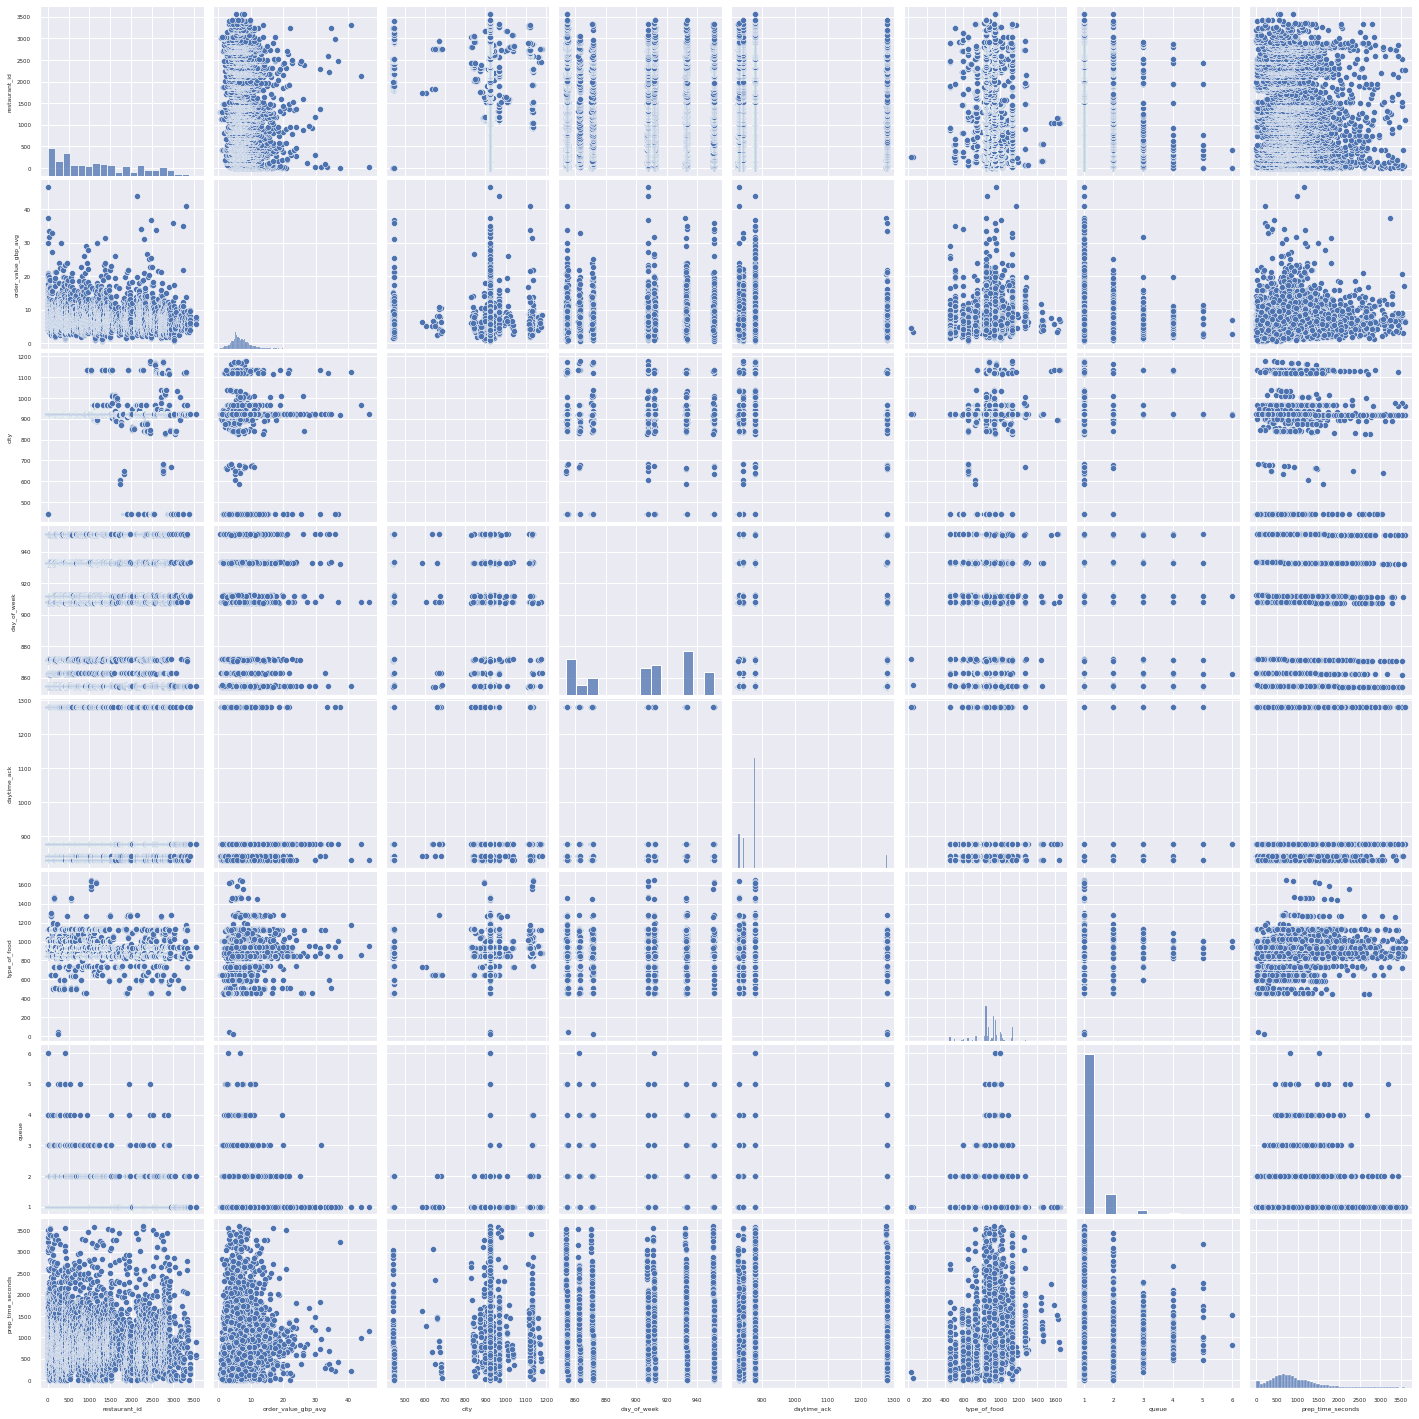

In [61]:
sns.set(font_scale=0.5)
sns.pairplot(pd.concat([X_test,y_test],axis=1))

#### Training and testing

In [62]:
best_res1 = best_regression(regression_methods = [lr,ls,lscv,rfr,xgbr], X = (X_train, X_test), y = (y_train, y_test))

Method <class 'sklearn.linear_model._base.LinearRegression'> performed with this rmse: 560.1957848084932
new min!
Method <class 'sklearn.linear_model._coordinate_descent.Lasso'> performed with this rmse: 560.2019474670027
Method <class 'sklearn.linear_model._coordinate_descent.LassoCV'> performed with this rmse: 561.0725464566888
Method <class 'sklearn.ensemble._forest.RandomForestRegressor'> performed with this rmse: 42.67812628317476
new min!
[14:19:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Method <class 'xgboost.sklearn.XGBRegressor'> performed with this rmse: 118.9955104250648


In [63]:
def test_data_creator(leave_out, fitted_est, ce_enc, 
                      drop_col_X: Union[str,list,None] = None):

    y_left = leave_out.prep_time_seconds
    X_left = ce_enc.enc_transform(leave_out.drop("prep_time_seconds",axis=1),y_left)
    if drop_col_X is not None:
        best_pred = fitted_est.predict(X_left.drop(drop_col_X,axis=1))
    else:
        best_pred = fitted_est.predict(X_left)
    print("rmse is: ",(mse(y_left,best_pred))**(1/2))
    test_data = pd.concat([X_left,y_left],axis = 1)
    test_data["pred"] = best_pred
    test_data["resid"] = ((test_data["prep_time_seconds"] - test_data["pred"])**2)**(1/2)
    return test_data

test_1 = test_data_creator(leave_out,best_res1[0],enc)

rmse is:  248.01158939482335


#### Residuals study
We will study how the residuals distribute across our dataset. Note that most of our residuals greater than 10 seconds come from restaurants who were present for even just one order in our dataset, making it harder for our method to contibute significantly. However, the rmse we had is only of 250 seconds on unseen data, which is not bad at all. 

Note that in the left out set there are restaurants who have never been seen by our algorythm, which opens a discussion on how can we improve further the performances. One might, for example, create a categorical encoding on target by leveraging on a Embeddings-LSTM Deep Neural Network architecture to create specific target encoding according to the food description. This, if done on a large enough dataset, allows for new description to be encoded effectively.

In [64]:
test_1.loc[test_1.resid>10,:]

,restaurant_id,order_value_gbp_avg,city,day_of_week,daytime_ack,type_of_food,queue,prep_time_seconds,pred,resid
473,611,14.133333,920.467505,911.111040,878.255814,1124.162033,1,3488,3460.35,27.65
715,862,4.900000,920.468372,861.938809,1278.212288,1124.174742,1,3472,3235.63,236.37
805,936,5.785714,1133.660550,854.674600,1279.443057,1167.444444,1,1008,989.35,18.65
807,936,4.212500,1135.002294,912.097522,842.427229,1189.111111,1,423,412.37,10.63
818,966,17.000000,1131.240826,950.772954,1278.916084,586.346705,1,2063,2129.08,66.08
...,...,...,...,...,...,...,...,...,...,...
3829,3589,6.950000,901.650761,854.760286,1279.568931,744.045635,1,756,2457.04,1701.04
3830,3589,5.366667,901.650761,854.784427,842.352606,744.186508,1,685,2676.06,1991.06
3833,3618,4.892394,878.666667,854.756885,842.329536,731.176238,1,766,443.77,322.23
3834,3620,3.975000,901.650761,854.271676,841.923099,645.758216,1,2193,2683.63,490.63


#### Other tests

On the test set, generated by taking the last segments of a particualr order chain for a particular restaurant, Random Forest did particularly well, managing to overtake also XGBoost. Now we analyze how residuals move wrt test data generated previously.

In [65]:
test2 = test_data_creator(test,best_res1[0],enc)

rmse is:  42.67812628317476


In [66]:
test2.loc[test2.resid>10,:]

,restaurant_id,order_value_gbp_avg,city,day_of_week,daytime_ack,type_of_food,queue,prep_time_seconds,pred,resid
60,9,11.949983,443.100666,871.000373,829.248926,900.144487,1,2045,2126.37,81.37
61,9,12.914719,442.308652,870.645678,828.956722,896.524715,2,2997,3098.72,101.72
62,9,8.518800,443.177205,871.034650,829.277164,900.494297,2,1953,1993.06,40.06
66,9,15.351588,443.750416,907.737700,878.420530,903.114068,2,1264,1253.56,10.44
68,9,9.938600,442.265391,932.436293,841.679294,896.326996,1,3049,3134.17,85.17
...,...,...,...,...,...,...,...,...,...,...
4931,3037,5.316667,837.401408,907.719108,829.468692,1129.069372,1,1329,1447.02,118.02
4933,3037,4.675000,842.133803,854.793948,829.674954,1129.948953,1,657,684.44,27.44
4934,3061,6.137500,840.147887,862.781177,878.444601,844.184408,1,939,922.10,16.90
4935,3061,7.750000,843.422535,862.935816,829.731123,844.329994,1,474,563.53,89.53


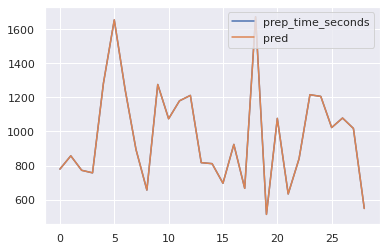

In [67]:
def plot_pred(test_data, example=0):
    sns.set(font_scale=1)
    plt.figure()
    test_data.loc[test_data.restaurant_id == test_data.restaurant_id.unique()[example],"prep_time_seconds"].plot()
    test_data.loc[test_data.restaurant_id == test_data.restaurant_id.unique()[example],"pred"].plot()
    plt.legend()
plot_pred(test2)

Our best method is Random Forest regressor. But wait! Very small rmse? It smells a bit. Let's investigate further. 

We might try with CV. But with Time Series Data CV is not the best. 

**Let's understand what's happening**, before singing Hoorray! But wait, let's first try in dropping `restaurant_id` from the training and test set.

#### Restaurant ID, yes or not?

A particular concern regards `restaurant_id`. In fact it might be too strict to use it in the training phase. So, we try by discarding it.

Results show that by discarding `restaurant_id`, the result even improves.

In [68]:
best_res2 = best_regression(regression_methods = [lr,ls,lscv,rfr,xgbr], X = (X_train.drop("restaurant_id",axis=1), X_test.drop("restaurant_id",axis=1)), y = (y_train, y_test))

Method <class 'sklearn.linear_model._base.LinearRegression'> performed with this rmse: 560.3373255217493
new min!
Method <class 'sklearn.linear_model._coordinate_descent.Lasso'> performed with this rmse: 560.3430152325986
Method <class 'sklearn.linear_model._coordinate_descent.LassoCV'> performed with this rmse: 561.341401913623
Method <class 'sklearn.ensemble._forest.RandomForestRegressor'> performed with this rmse: 43.63842525369199
new min!
[14:19:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Method <class 'xgboost.sklearn.XGBRegressor'> performed with this rmse: 118.98574561029537


The model selected has also an excellent $R^2$!

In [69]:
best_res2[0].score(X_test.drop("restaurant_id",axis=1),y_test)

0.9944596957344898

Now we try on unseen data:

In [70]:
test_3 = test_data_creator(leave_out,best_res2[0],enc,"restaurant_id")

rmse is:  244.28371578623907


On totally unseen data, the performance is quite good! rmse of 240 seconds is even better than before (almost 10 seconds less)!

On test data, instead:

In [71]:
test_4 = test_data_creator(test,best_res2[0],enc,"restaurant_id")

rmse is:  43.63842525369199


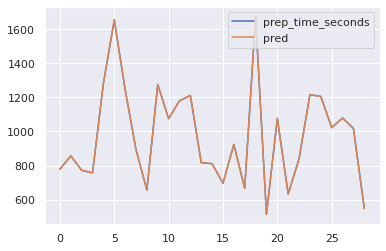

In [72]:
plot_pred(test_4)

### Ordinal Encoder

We will try OrdinalEncoder. However, it doesn't fit really well. The rmse increases by a factor of 10 and more.

In [73]:
enc = CategoricalEncoding(ce.OrdinalEncoder,cols=["city", "day_of_week", "daytime_ack", "type_of_food"])

In [74]:
y_train = train.prep_time_seconds
y_test = test.prep_time_seconds
X_train, X_test = enc([train.drop("prep_time_seconds",axis=1),y_train],[test.drop("prep_time_seconds",axis=1),y_test])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [75]:
best_res3 = best_regression(regression_methods = [lr,ls,lscv,rfr,xgbr], X = (X_train, X_test), y = (y_train, y_test))

Method <class 'sklearn.linear_model._base.LinearRegression'> performed with this rmse: 581.6130360846821
new min!
Method <class 'sklearn.linear_model._coordinate_descent.Lasso'> performed with this rmse: 581.4892575694514
new min!
Method <class 'sklearn.linear_model._coordinate_descent.LassoCV'> performed with this rmse: 581.132513531583
new min!
Method <class 'sklearn.ensemble._forest.RandomForestRegressor'> performed with this rmse: 561.388934642266
new min!
[14:19:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Method <class 'xgboost.sklearn.XGBRegressor'> performed with this rmse: 549.4665351029571
new min!


On unseen data this model is underperforming, in fact:

In [76]:
test_ord_unseen = test_data_creator(leave_out,best_res3[0],enc)

rmse is:  653.8697428233113


Also on test data, it performs really bad.

In [77]:
test_ord_test = test_data_creator(test,best_res3[0],enc)

rmse is:  549.4665351029571


The model isn't able to match correctly the test data, even.

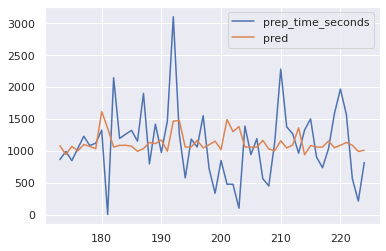

In [78]:
plot_pred(test_ord_test,12)

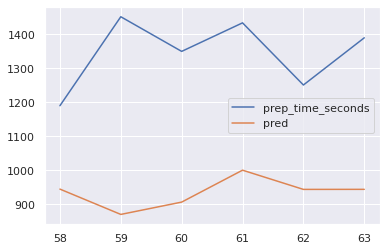

In [79]:
plot_pred(test_ord_unseen,12)

Ordinal Encoder doesn't fit well. Actually, LeaveOneOut encoder fits the best due to the fact, for each timestep in our training set, we have that different levels of target encoding. In particular, recall that:

- `day_of_week` encoding tells us how much a particular day of the week contributes, on average, on preparation time
- `daytime_ack` encoding tells us how much the particular daytime contributes to the average value of preparation time
- `city` encoding gives the contribution at city level on the average value of preparation time
- `type_of_food` gives the contribution at cuisine level on the average value of preparation time

The data leakage has been studied and we don't see any evidence of it in LeaveOneOut method. Therefore, the best method is LeaveOneOut with train and test built by leaving out the future at restaurant level.

# Conclusions

Leave One Out encoder is the one that performs better. I have splitted the dataset into train and test by including in the test only the observations that are 20% into the future. Then we encode the categorical features by fitting only on the train set with leave one out. This strategy allowed to avoid data leakage from the future, creating a bidirectional encoding on the train set.

## Future implementation

In order to improve such architecture we might work on word embeddings to encode textual data with word vectors. This gives us, given enough data, more flexibility on unseen data.

Another improvement might be to implement hyperopt to decide the best models, by searching through a set of hyperparameters, each one specific to that particular model. Hyperopt is particularly useful because with a `SparkTrial` object can leverage on a Spark cluster to fasten fitting process and parameter tuning.